In [221]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from utilities.build_augmentor import TransformDataset
from skimage.filters import gaussian
from skimage import transform, feature
from skimage.transform import swirl, AffineTransform, warp
import cv2
from skimage.color import rgb2gray
from scipy.ndimage.interpolation import map_coordinates
from skimage.util import random_noise
from scipy.ndimage import rotate
from scipy.ndimage.filters import median_filter
%matplotlib inline

In [37]:
cifar = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar.load_data()
im = x_train[14]

In [222]:
def scale(X, x_min=0, x_max=1):
        nom = (X-X.min(axis=0))*(x_max-x_min)
        denom = X.max(axis=0) - X.min(axis=0)
        denom[denom==0] = 1
        X_new = x_min + nom/denom
        return (X_new)
    
def gaussian_noise(x, severity=2):
    c = [.08, .12, 0.18, 0.26, 0.38][severity - 1]

    x = np.array(x) / 255.
    x = np.clip(x + np.random.normal(size=x.shape, scale=c), 0, 1) * 255
    return x.astype(np.float32)

def speckle_noise(x, severity=2):
    c = [.15, .2, 0.35, 0.45, 0.6][severity - 1]

    x = np.array(x) / 255.
    x = np.clip(x + x * np.random.normal(size=x.shape, scale=c), 0, 1) * 255
    return x.astype(np.float32)

def gaussian_blur(x, severity=1):
    c = [1, 2, 3, 4, 6][severity - 1]

    x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
    x = np.clip(x, 0, 1) * 255
    return x.astype(np.float32)

def shear(x, severity=2):
    c = [0.2, 0.4, 0.6, 0.8, 1.][severity-1]
    
    # Randomly switch directions
    bit = np.random.choice([-1, 1], 1)[0]
    c *= bit
    aff = transform.AffineTransform(shear=c)

    # Calculate translation in order to keep image center (13.5, 13.5) fixed
    a1, a2 = aff.params[0,:2]
    b1, b2 = aff.params[1,:2]
    a3 = 13.5 * (1 - a1 - a2)
    b3 = 13.5 * (1 - b1 - b2)
    aff = transform.AffineTransform(shear=c, translation=[a3, b3])
    
    x = np.array(x) / 255.
    x = transform.warp(x, inverse_map=aff)
    x = np.clip(x, 0, 1) * 255.
    return x.astype(np.float32)

def translate(x, severity=2):
    c = [1, 2, 3, 4, 5][severity-1]
    bit = np.random.choice([-1, 1], 2)
    dx = c * bit[0]
    dy = c * bit[1]
    aff = transform.AffineTransform(translation=[dx, dy])
    
    x = np.array(x) / 255.
    x = transform.warp(x, inverse_map=aff)
    x = np.clip(x, 0, 1) * 255
    return x.astype(np.float32)

def rotate_np(im, angle=None):
    sign = -1 if np.random.uniform(low=0, high=1) < 0.5 else 1
    if angle is None:
        angle = np.random.uniform(low=5, high=45) * -1
    angle *= sign
    return rotate(im, angle, reshape=False, mode='nearest')

def flip_rotate(im, choice=None):
    if choice is None: 
        choice = 'vertical' if np.random.uniform(low=0, high=1) < 0.5 else 'horizontal'
    im = flip_vertical_np(im) if choice == 'vertical' else flip_horizontal_np(im)
    return rotate_np(im)

def perform_random_affine_transform(im):
    # populating random values
    scale_x, scale_y = np.random.uniform(1.0, 1.35), np.random.uniform(1.0, 1.3)
    tf_x, tf_y = np.random.uniform(0.0, 0.1), np.random.uniform(0.0, 0.1)
    shear = np.random.uniform(0.0, 0.15)
    tf_inv_matrix = AffineTransform(scale=(scale_x, scale_y), shear=shear, translation=(tf_x, tf_y)).inverse
    
    if np.random.uniform(low=0, high=1) < 0.15:
        im = perform_swirl_transformation(im)
    return warp(im, tf_inv_matrix, order=0)

def perform_swirl_transformation(im, angle=None):
    sign = -1 if np.random.uniform(low=0, high=1) < 0.5 else 1
    if angle is None:
        angle = np.random.uniform(low=5, high=20) * -1
    angle *= sign
    return swirl(im, strength=.2, rotation=angle)

def canny_edges(x):
    #x = np.array(x) / 255.
    x = feature.canny(x).astype(np.float32)
    return x * 255

def elastic_transform(image, severity=1):
    c = [(28 * 2, 28 * 0.7, 28 * 0.1),
         (28 * 2, 28 * 0.08, 28 * 0.2),
         (28 * 0.05, 28 * 0.01, 28 * 0.02),
         (28 * 0.07, 28 * 0.01, 28 * 0.02),
         (28 * 0.12, 28 * 0.01, 28 * 0.02)][severity - 1]

    image = np.array(image, dtype=np.float32) / 255.
    shape = image.shape

    # random affine
    center_square = np.float32(shape) // 2
    square_size = min(shape) // 3
    pts1 = np.float32([center_square + square_size,
                       [center_square[0] + square_size, center_square[1] - square_size],
                       center_square - square_size])
    pts2 = pts1 + np.random.uniform(-c[2], c[2], size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape, borderMode=cv2.BORDER_CONSTANT)

    dx = (gaussian(np.random.uniform(-1, 1, size=shape),
                   c[1], mode='reflect', truncate=3) * c[0]).astype(np.float32)
    dy = (gaussian(np.random.uniform(-1, 1, size=shape),
                   c[1], mode='reflect', truncate=3) * c[0]).astype(np.float32)

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))
    return np.clip(map_coordinates(image, indices, order=1, mode='constant').reshape(shape), 0, 1) * 255

def add_sp_noise(im):
    ''' Adds Salt and Pepper Noise to the Image '''
    final_img = np.zeros_like(im, np.float64)
    _, _, C = im.shape
    for i in range(C):
        amt = np.random.randint(1, 5) / 1e3
        noise = random_noise(im[:, :, i], mode='s&p', amount=amt)
        final_img[:, :, i] = np.array(255*noise)
    return final_img.astype(np.uint8)

def flip_vertical_np(im):
    return np.flipud(im)

def flip_horizontal_np(im):
    return np.fliplr(im)

def mixed_transformations(im):
    # Flip Rotate + Swirl + Affine Transformation
    choice = 'vertical' if np.random.uniform(low=0, high=1) < 0.5 else 'horizontal'
    im = flip_vertical_np(im) if choice == 'vertical' else flip_horizontal_np(im)
    return perform_random_affine_transform(perform_swirl_transformation(im))

def random_image_eraser(im):
    ''' Utility for random image masking '''
    im_ = im.copy()
    H, W, C = im_.shape
    point = np.random.randint(int(H/5), int(H/2))
    w_ = np.random.randint(int(W/5), int(W/2))
    h_ = np.random.randint(int(H/5), int(H/2))
    im_[point:point + h_, point:point + w_, :] = np.random.uniform(0, 255)
    return im_.astype(np.uint8)

def median_filtering(im, k=2):
    ''' Performs Median filtering on the image'''
    corrected = median_filter(im, size=(k, k, k))
    return (corrected*255).astype(np.uint8)

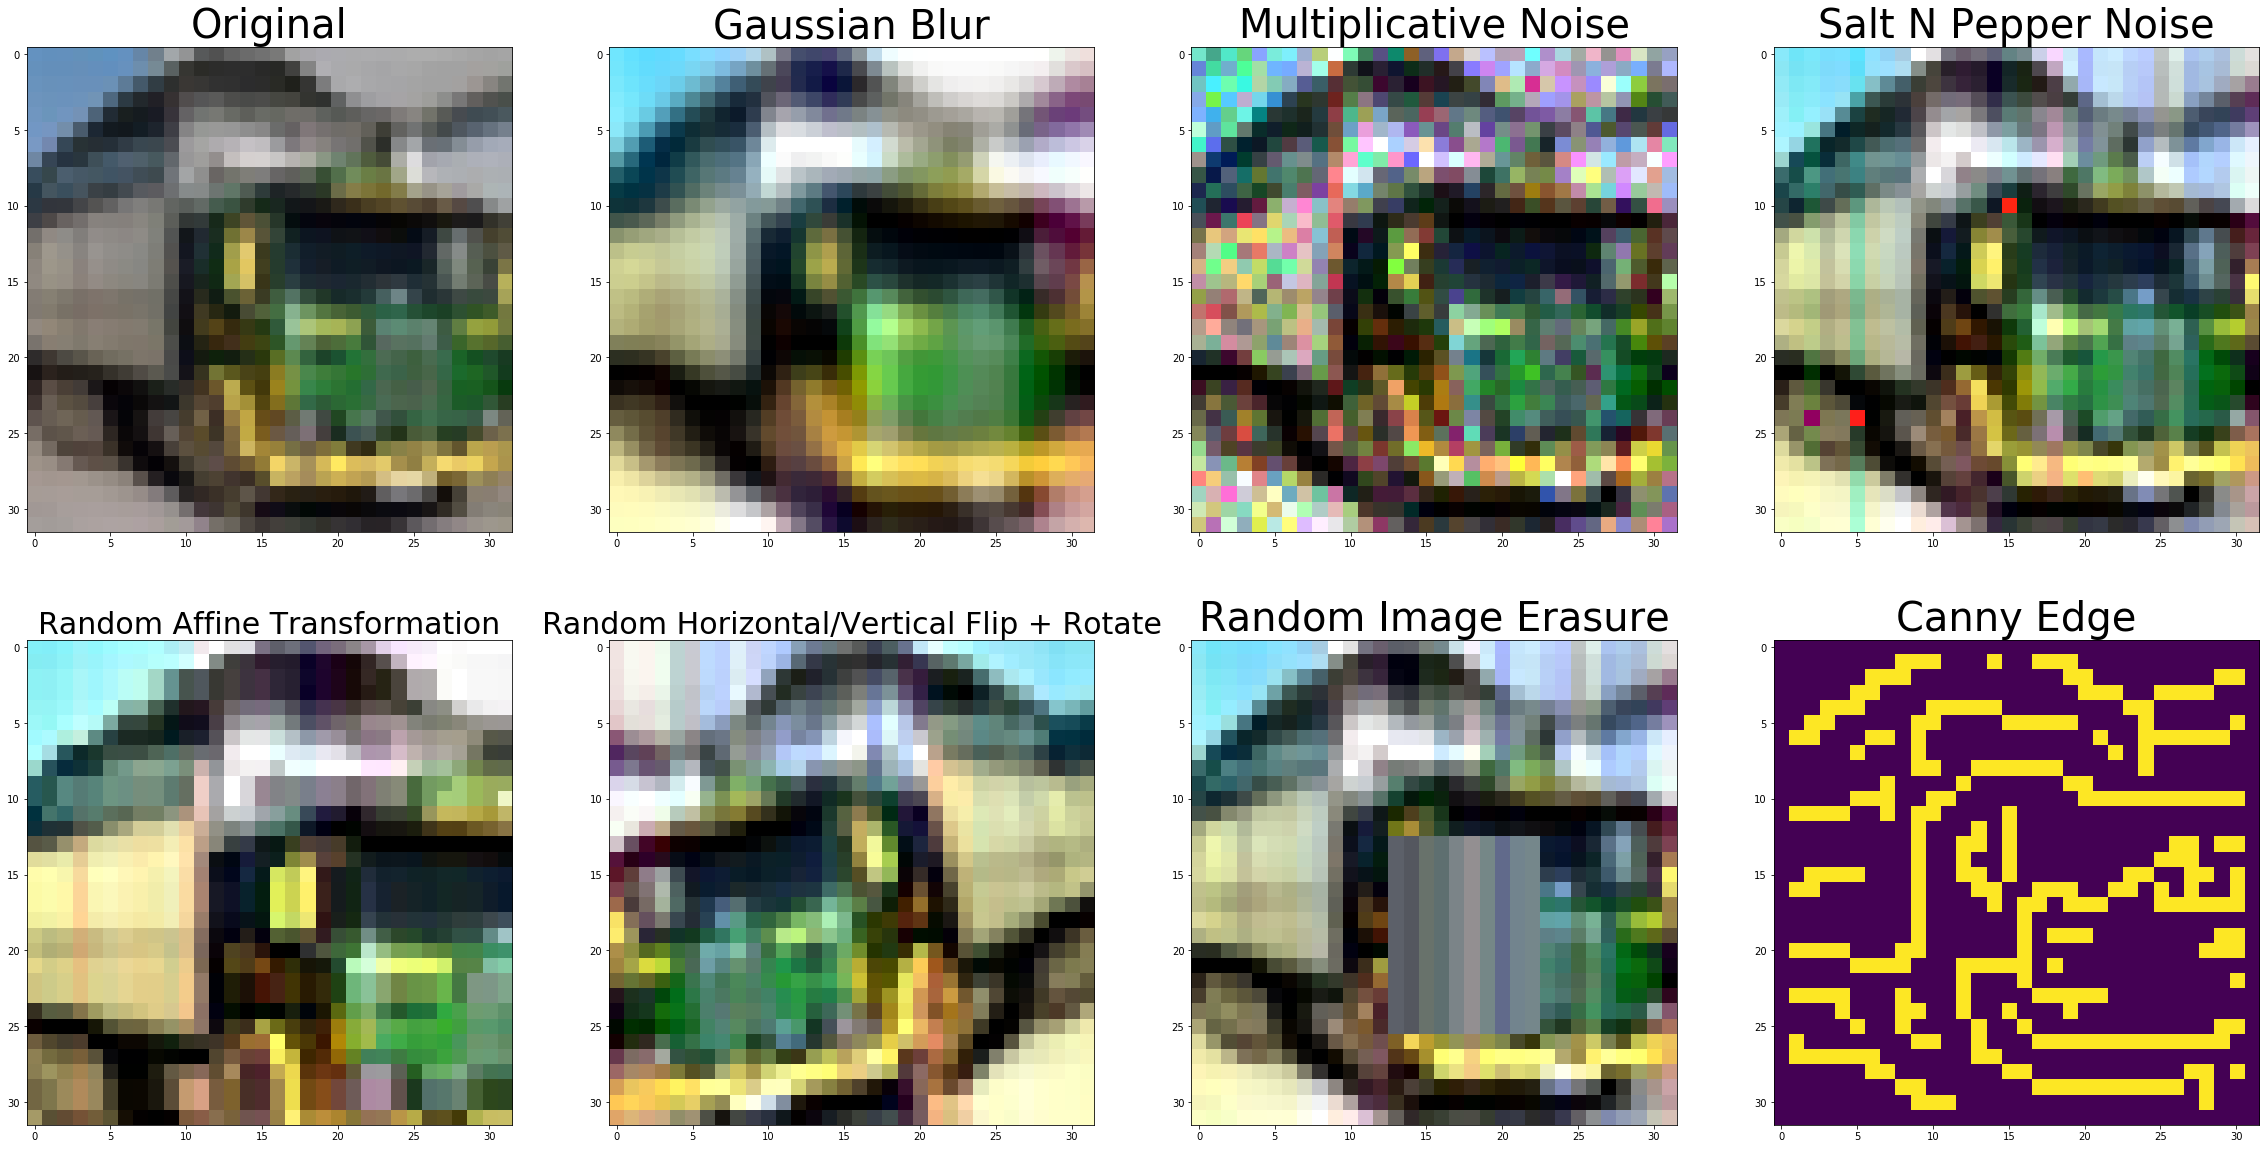

In [238]:
plt.figure(figsize=(40, 20))
plt.subplot(2, 4, 1)
plt.imshow(im)
plt.title('Original', fontdict = {'fontsize' : 40})
plt.subplot(2, 4, 2)
plt.imshow(scale(gaussian_blur((im))))
plt.title('Gaussian Blur', fontdict = {'fontsize' : 40})
plt.subplot(2, 4, 3)
plt.imshow(scale(speckle_noise((im))))
plt.title('Multiplicative Noise', fontdict = {'fontsize' : 40})
plt.subplot(2, 4, 4)
plt.imshow(scale(add_sp_noise((im))))
plt.title('Salt N Pepper Noise', fontdict = {'fontsize' : 40})
plt.subplot(2, 4, 5)
plt.imshow(scale(perform_random_affine_transform((im))))
plt.title('Random Affine Transformation', fontdict = {'fontsize' : 30})
plt.subplot(2, 4, 6)
plt.imshow(scale(flip_rotate((im))))
plt.title('Random Horizontal/Vertical Flip + Rotate', fontdict = {'fontsize' : 30})
plt.subplot(2, 4, 7)
plt.imshow(scale(random_image_eraser((im))))
plt.title('Random Image Erasure', fontdict = {'fontsize' : 40})
plt.subplot(2, 4, 8)
plt.imshow(scale(canny_edges(rgb2gray(im))))
plt.title('Canny Edge', fontdict = {'fontsize' : 40})
plt.show()

In [209]:
im.shape

(32, 32, 3)

In [208]:
plt.imshow(elastic_transform(im))

ValueError: setting an array element with a sequence.

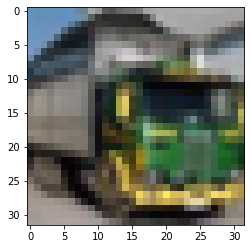

In [52]:
plt.imshow(im)

In [49]:
gaussian_noise(im)

array([[[201.39096  ,  80.61067  , 116.96391  ],
        [173.32018  ,  26.0658   , 241.72691  ],
        [255.       ,  66.8523   , 250.96332  ],
        ...,
        [ 57.159172 ,  46.153202 ,  94.55987  ],
        [255.       , 254.14665  , 162.07597  ],
        [255.       , 255.       ,   0.       ]],

       [[ 90.3328   , 202.24182  , 106.55022  ],
        [  0.       ,  31.515049 , 169.82596  ],
        [ 59.01374  , 162.1751   ,  99.23028  ],
        ...,
        [191.92107  , 166.06544  , 255.       ],
        [  0.       , 218.33897  ,   0.       ],
        [255.       ,  67.62068  , 146.2206   ]],

       [[145.04259  , 228.67284  , 132.24783  ],
        [129.57382  , 227.1594   , 224.13576  ],
        [  0.       , 106.596825 , 175.08093  ],
        ...,
        [255.       ,  11.9003935, 255.       ],
        [ 84.18216  , 255.       ,   0.       ],
        [ 95.864784 , 148.68497  , 146.28749  ]],

       ...,

       [[201.8921   ,  97.10933  ,  78.92311  ],
        [ 2

(15000, 32, 32, 3)